✅ Dataset Loaded. Shape: (11229, 16)
Index(['datetime', 'Longitude', 'Latitude', 'UHI Index', 'Land_Surface_Temp',
       'Band1', 'Band2', 'Band3', 'Band4', 'air_temp_at_surface_[degc]',
       'relative_humidity_[percent]', 'avg_wind_speed_[m/s]',
       'wind_direction_[degrees]', 'solar_flux_[w/m^2]',
       'Nearest_Building_Lon', 'Nearest_Building_Lat', 'Building_Distance_m',
       'Building_Density_50m', 'Building_Density_100m',
       'Building_Density_200m'],
      dtype='object')
✅ Extracted Temporal Features: 'hour', 'weekday', 'month'
             datetime  hour  weekday  month
0 2021-07-24 15:53:00    15        5      7
1 2021-07-24 15:53:00    15        5      7
2 2021-07-24 15:53:00    15        5      7
3 2021-07-24 15:53:00    15        5      7
4 2021-07-24 15:53:00    15        5      7
✅ Cleaned Dataset Saved: ../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv
📌 Final Column Names: ['datetime', 'longitude', 'latitude', 'uhi_index', 'land_surfa

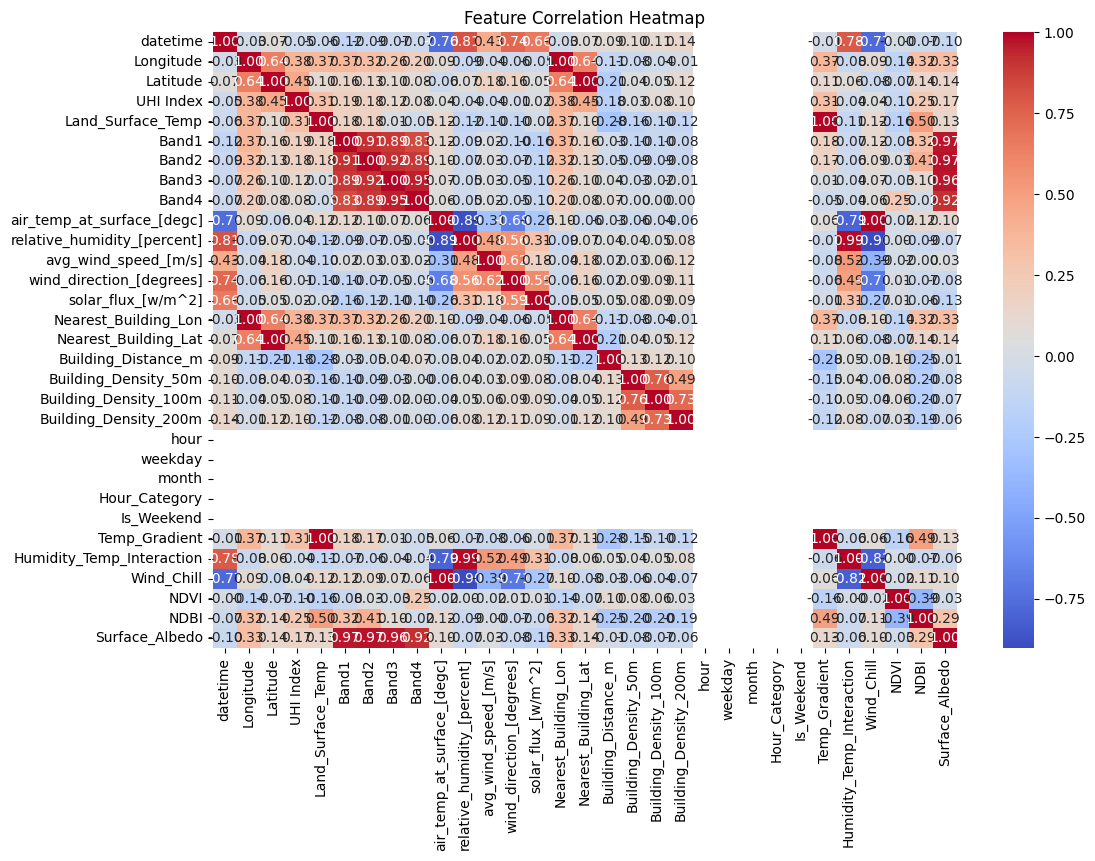

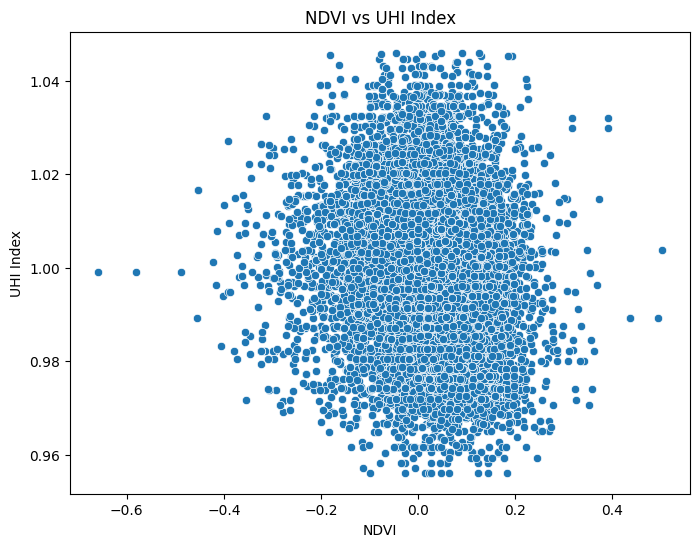

In [12]:
# 📌 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from haversine import haversine, Unit

# ----------------- 1️⃣ Load Processed Data -----------------
data_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Merged.csv"
df = pd.read_csv(data_path)
print(f"✅ Dataset Loaded. Shape: {df.shape}")

# ----------------- 2️⃣ Spatial Feature Engineering -----------------
## ✅ Distance to Nearest Building (Haversine Distance)
def calculate_haversine_distance(row):
    return haversine(
        (row["Latitude"], row["Longitude"]),
        (row["Nearest_Building_Lat"], row["Nearest_Building_Lon"]),
        unit=Unit.METERS
    )

df["Building_Distance_m"] = df.apply(calculate_haversine_distance, axis=1)

## ✅ Building Density within 50m, 100m, 200m
def compute_density(df, radius):
    tree = cKDTree(df[["Longitude", "Latitude"]])
    count = tree.query_ball_point(df[["Longitude", "Latitude"]], r=radius, return_length=True)
    return count - 1  # Exclude the current point

df["Building_Density_50m"] = compute_density(df, 0.00045)  # Approx. 50m
df["Building_Density_100m"] = compute_density(df, 0.0009)  # Approx. 100m
df["Building_Density_200m"] = compute_density(df, 0.0018)  # Approx. 200m

print(df.columns)

# Ensure datetime is in the correct format
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Extract hour, weekday, and month
df["hour"] = df["datetime"].dt.hour
df["weekday"] = df["datetime"].dt.weekday  # Monday = 0, Sunday = 6
df["month"] = df["datetime"].dt.month

print("✅ Extracted Temporal Features: 'hour', 'weekday', 'month'")
print(df[["datetime", "hour", "weekday", "month"]].head())

# ----------------- 3️⃣ Temporal Feature Engineering -----------------
## ✅ Hour Categorization
df["Hour_Category"] = pd.cut(
    df["hour"], bins=[0, 6, 12, 18, 24], labels=["Night", "Morning", "Afternoon", "Evening"], include_lowest=True
)

## ✅ Weekday vs Weekend
df["Is_Weekend"] = df["weekday"].apply(lambda x: 1 if x >= 5 else 0)

# ----------------- 4️⃣ Weather Feature Engineering -----------------
## ✅ Temperature Gradient (LST - Air Temperature)
df["Temp_Gradient"] = df["Land_Surface_Temp"] - df["air_temp_at_surface_[degc]"]

## ✅ Humidity-Temperature Interaction
df["Humidity_Temp_Interaction"] = df["relative_humidity_[percent]"] * df["air_temp_at_surface_[degc]"]

## ✅ Wind Chill Index
df["Wind_Chill"] = 13.12 + 0.6215 * df["air_temp_at_surface_[degc]"] - 11.37 * (df["avg_wind_speed_[m/s]"] ** 0.16) + 0.3965 * df["air_temp_at_surface_[degc]"] * (df["avg_wind_speed_[m/s]"] ** 0.16)

# ----------------- 5️⃣ Satellite Feature Engineering -----------------
## ✅ Normalized Difference Vegetation Index (NDVI)
df["NDVI"] = (df["Band4"] - df["Band3"]) / (df["Band4"] + df["Band3"] + 1e-6)  # Avoid division by zero

## ✅ Normalized Difference Built-Up Index (NDBI)
df["NDBI"] = (df["Band2"] - df["Band4"]) / (df["Band2"] + df["Band4"] + 1e-6)

## ✅ Surface Albedo Approximation
df["Surface_Albedo"] = df[["Band1", "Band2", "Band3"]].mean(axis=1) / 10000  # Normalize reflectance

# 📌 Load Processed Dataset (Ensure this is defined)
feature_engineered_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Featured.csv"
uhi_df = pd.read_csv(feature_engineered_path)

# ✅ Function to Clean Column Names

def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()         # Remove leading/trailing spaces
               .str.lower()            # Convert to lowercase
               .str.replace(" ", "_")  # Replace spaces with underscores
               .str.replace(r"\[", "", regex=True)  # Remove opening bracket safely
               .str.replace(r"\]", "", regex=True)  # Remove closing bracket safely
    )
    return df

# 🛠️ Apply Column Name Cleaning
uhi_df = clean_column_names(uhi_df)

# ✅ Save Cleaned Dataset
cleaned_path = "../data/processed/UHI_Weather_Building_Sentinel_LST_Featured_Cleaned.csv"
uhi_df.to_csv(cleaned_path, index=False)

print(f"✅ Cleaned Dataset Saved: {cleaned_path}")
print("📌 Final Column Names:", uhi_df.columns.tolist())

# ----------------- 🔍 7️⃣ Visualizations -----------------
## ✅ Correlation Heatmap
plt.figure(figsize=(12, 8))
# Convert Hour_Category into numerical values
hour_category_map = {"Night": 0, "Morning": 1, "Afternoon": 2, "Evening": 3}
df["Hour_Category"] = df["Hour_Category"].map(hour_category_map)
df["Is_Weekend"] = df["Is_Weekend"].astype(int)
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## ✅ Scatter Plot: NDVI vs UHI Index
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["NDVI"], y=df["UHI Index"])
plt.title("NDVI vs UHI Index")
plt.xlabel("NDVI")
plt.ylabel("UHI Index")
plt.show()

In [6]:
df.dtypes

datetime                       datetime64[ns]
Longitude                             float64
Latitude                              float64
UHI Index                             float64
Land_Surface_Temp                     float64
Band1                                 float64
Band2                                 float64
Band3                                 float64
Band4                                 float64
air_temp_at_surface_[degc]            float64
relative_humidity_[percent]           float64
avg_wind_speed_[m/s]                  float64
wind_direction_[degrees]              float64
solar_flux_[w/m^2]                    float64
Nearest_Building_Lon                  float64
Nearest_Building_Lat                  float64
Building_Distance_m                   float64
Building_Density_50m                    int64
Building_Density_100m                   int64
Building_Density_200m                   int64
hour                                    int32
weekday                           

In [7]:
df.isnull().sum()

datetime                       0
Longitude                      0
Latitude                       0
UHI Index                      0
Land_Surface_Temp              0
Band1                          0
Band2                          0
Band3                          0
Band4                          0
air_temp_at_surface_[degc]     0
relative_humidity_[percent]    0
avg_wind_speed_[m/s]           0
wind_direction_[degrees]       0
solar_flux_[w/m^2]             0
Nearest_Building_Lon           0
Nearest_Building_Lat           0
Building_Distance_m            0
Building_Density_50m           0
Building_Density_100m          0
Building_Density_200m          0
hour                           0
weekday                        0
month                          0
Hour_Category                  0
Is_Weekend                     0
Temp_Gradient                  0
Humidity_Temp_Interaction      0
Wind_Chill                     0
NDVI                           0
NDBI                           0
Surface_Al